# Module 4 Homework Assignment
_Megan Walker-Radtke_

### Assignment Description
1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)


2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. 

3) Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)
   
4) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

5) Plot the percent of variance explained by the first 10 EOFs.

6) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

7) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?


In [2]:
# Import necessary libraries and packages

import numpy as np
import xarray as xr
import pandas as pd

from sklearn import preprocessing

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

### Step 1

Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

In [3]:
# set filepaths to SST data
filepath_in = '/Users/meganwalker/MDW Docs/Academic/Univ Illinois/ATMS 523/module4/ATMS-523-Module-4/data/'
filename_in = 'data_stream-moda_stepType-avgua.nc'


In [4]:
SST_ERA5_raw = xr.open_dataset(filepath_in + filename_in)
SST_ERA5_raw

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver      (valid_time) <U4 9kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 2GB ...
    tcrw        (valid_time, latitude, longitude) float32 2GB ...
    lsm         (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-21T18:04 GRIB to CDM+CF via cfgrib-0.9.1...

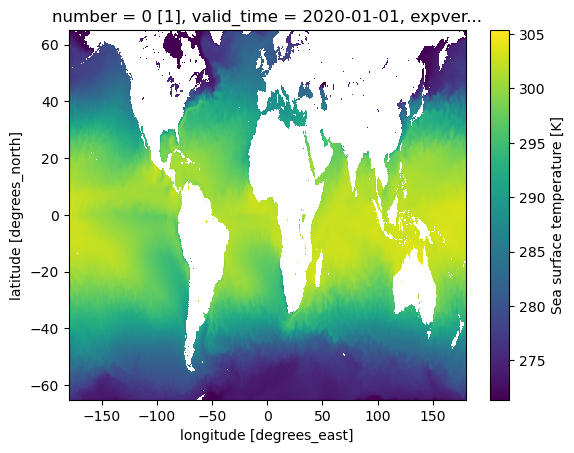

In [5]:
# confirm data is what we expect
SST_ERA5_raw['sst'].sel(valid_time='2020-01-01').plot()

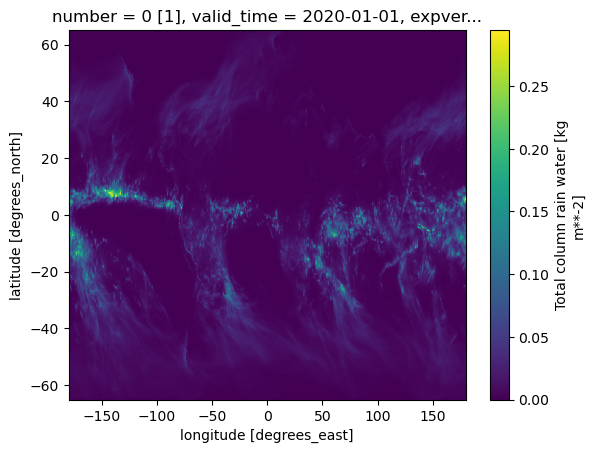

In [6]:
SST_ERA5_raw['tcrw'].sel(valid_time='2020-01-01').plot()

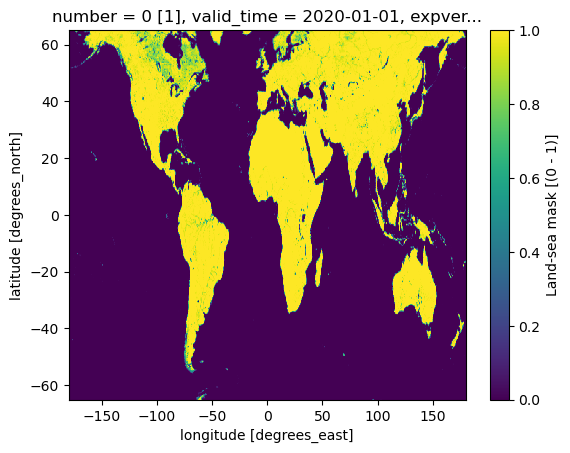

In [7]:
# check out what the land-sea mask looks like

SST_ERA5_raw['lsm'].sel(valid_time='2020-01-01').plot()

# ocean is where lsm == 0

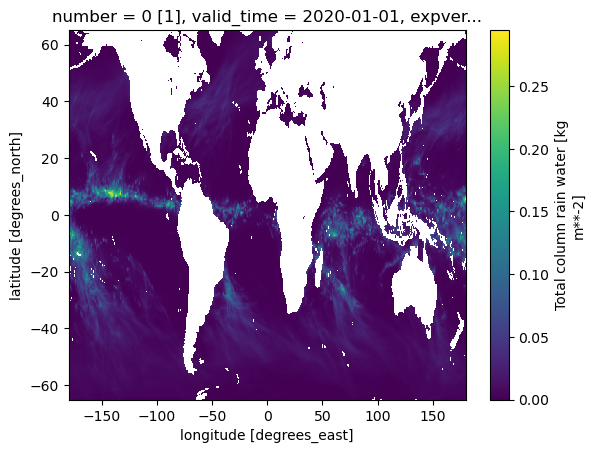

In [8]:
# Mask values over land, keeping only those values over the ocean (SST_ERA5_raw['lsm'] == 0)
ERA5_masked = SST_ERA5_raw.where(SST_ERA5_raw['lsm'] == 0)

# check that the masking worked
ERA5_masked['tcrw'].sel(valid_time='2020-01-01').plot()


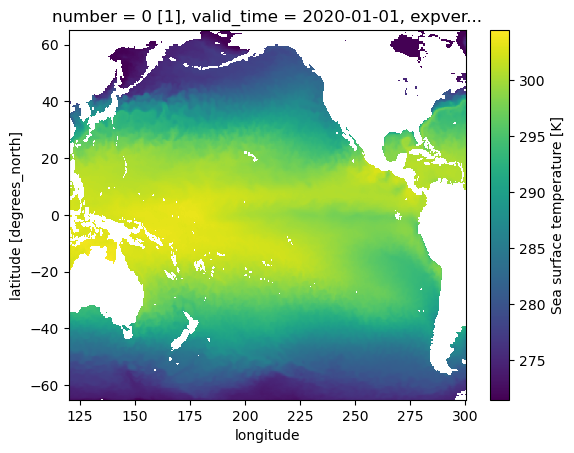

In [26]:
# subset spatially over the Pacific Basin (65°N to 65°S, 120°E to 60°W)
# First, adjust longitude coordinates from -180 to 180 to 0 to 360
ERA5_masked_lon = ERA5_masked.assign_coords(
    longitude=(ERA5_masked.longitude % 360)
).sortby('longitude')

# Now subset the data
ERA5_masked_lon = ERA5_masked_lon.sel(longitude=slice(120, 300)
)

# check the subsetted data
ERA5_masked_lon['sst'].sel(valid_time='2020-01-01').plot()

In [28]:
# rename back to original DS name
ERA5_masked = ERA5_masked_lon

### Step 2
From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. 

In [29]:
# Gratefully accepting the assist in detrending and calculating anomalies 

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


# Example:
# ds is a monthly ERA5 Dataset or DataArray with dimension "time"
# If Dataset, all variables get processed; if DataArray, just that variable
# ds = ds.chunk({"time": -1})  # optional: ensure time is a single chunk for speed
# Optional: keep time in one chunk for speed

ERA5_masked = ERA5_masked.chunk({"valid_time": -1})

detr = linear_detrend(ERA5_masked[["sst", "tcrw"]], time_dim="valid_time")   # or just ds if you want all float vars
anom, z = monthly_anom_and_z(detr, time_dim="valid_time",
                             base_period=("1981-01-01", "2010-12-31"))  # or None for full-period

print(type(z), list(z.data_vars))   # should show a Dataset with ['sst','tcrw']


<class 'xarray.core.dataset.Dataset'> ['sst', 'tcrw']


In [30]:
detr

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(552, 521, 721), meta=np.ndarray>
    tcrw        (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(552, 521, 721), meta=np.ndarray>

In [31]:
anom

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(1, 521, 721), meta=np.ndarray>
    tcrw        (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(1, 521, 721), meta=np.ndarray>

In [32]:
z

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(1, 521, 721), meta=np.ndarray>
    tcrw        (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(1, 521, 721), meta=np.ndarray>

### Step 3

Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

In [33]:


# when I tried to simply run preprocessing.StandardScaler().fit(anom['sst']) as shown in the scikit-learn documentation, I got an error that only 2 dimensions are allowed
# so apparently I need to flatten all lat/lon points into a single dimension in order to do these calculations

# Stack spatial dimensions into a single dimension
sst_stacked = anom['sst'].stack(points=('latitude', 'longitude'))

# Drop all-NaN points (e.g., land)
sst_valid = sst_stacked.dropna('points', how='all')

# Transpose so shape is (time, points)
sst_valid = sst_valid.transpose('valid_time', 'points')

# Fit scaler
scaler = preprocessing.StandardScaler().fit(sst_valid)

# To transform and put back into xarray:
sst_scaled = xr.full_like(sst_stacked, np.nan)
sst_scaled.loc[dict(points=sst_valid.points)] = scaler.transform(sst_valid)
sst_scaled = sst_scaled.unstack('points')




In [34]:
sst_scaled

<xarray.DataArray 'sst' (valid_time: 552, latitude: 521, longitude: 721)> Size: 829MB
dask.array<reshape, shape=(552, 521, 721), dtype=float32, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12

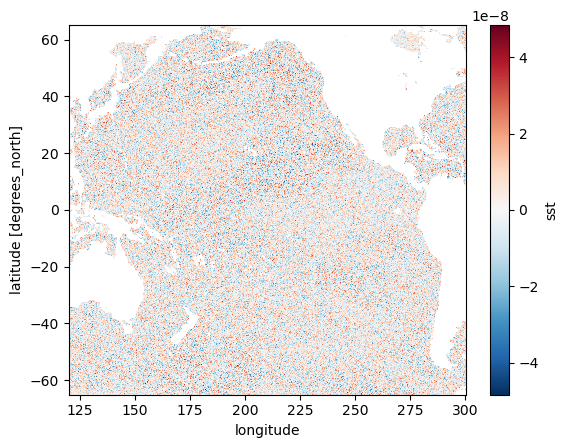

In [35]:
sst_scaled.mean(axis=0).plot()

# that's close to the expected value of 0, which suggests the standardization worked

### Step 4

Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

In [36]:
"""
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.

coslat = np.cos(np.deg2rad(sst_scaled.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_scaled, weights=wgts)

# this code caused my kernel to crash, which appears to be due to insufficient memory, so trying to run it using dask
"""

: 

In [17]:

"""
import dask.array as da

# Chunk the data along the time dimension only (all spatial data in one chunk)
sst_scaled_dask = sst_scaled.chunk({'valid_time': 10, 'latitude': -1, 'longitude': -1})

# Compute weights as a DataArray and broadcast to 2D (latitude, longitude)
coslat = np.cos(np.deg2rad(sst_scaled_dask.coords['latitude']))
wgts = np.sqrt(coslat)
wgts_2d = wgts.broadcast_like(sst_scaled_dask.isel(valid_time=0))

# Pass the dask-backed array to Eof
solver = Eof(sst_scaled_dask, weights=wgts_2d)

# this still doesn't work - still crashes my kernel 
# moving on to attempt #3 of doing this component of the assignment
"""



"\nimport dask.array as da\n\n# Chunk the data along the time dimension only (all spatial data in one chunk)\nsst_scaled_dask = sst_scaled.chunk({'valid_time': 10, 'latitude': -1, 'longitude': -1})\n\n# Compute weights as a DataArray and broadcast to 2D (latitude, longitude)\ncoslat = np.cos(np.deg2rad(sst_scaled_dask.coords['latitude']))\nwgts = np.sqrt(coslat)\nwgts_2d = wgts.broadcast_like(sst_scaled_dask.isel(valid_time=0))\n\n# Pass the dask-backed array to Eof\nsolver = Eof(sst_scaled_dask, weights=wgts_2d)\n\n# this still doesn't work - still crashes my kernel \n# moving on to attempt #3 of doing this component of the assignment\n"

In [23]:

# Attempt # 3 at EOF analysis:
# Coarsen the SST data before EOF analysis to reduce memory usage
# This averages every 4x4 grid cells (adjust factor as needed)
sst_coarse = sst_scaled.coarsen(latitude=4, longitude=4, boundary='trim').mean()

# EOFs solver expects 'time' dimension, so rename 'valid_time' to 'time'
sst_coarse_renamed = sst_coarse.rename({'valid_time': 'time'})
sst_coarse_dask = sst_coarse_renamed.chunk({'time': 10, 'latitude': -1, 'longitude': -1})

# Compute weights for the coarsened grid
coslat = np.cos(np.deg2rad(sst_coarse_dask.coords['latitude']))
wgts = np.sqrt(coslat)
wgts_2d = wgts.broadcast_like(sst_coarse_dask.isel(time=0))

# Pass the coarsened, dask-backed array to Eof
solver = Eof(sst_coarse_dask, weights=wgts_2d)


In [24]:
# Time to plot the results

# Retrieve the leading 10 EOFs and PC time series

eof1 = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/xarray-climate/l

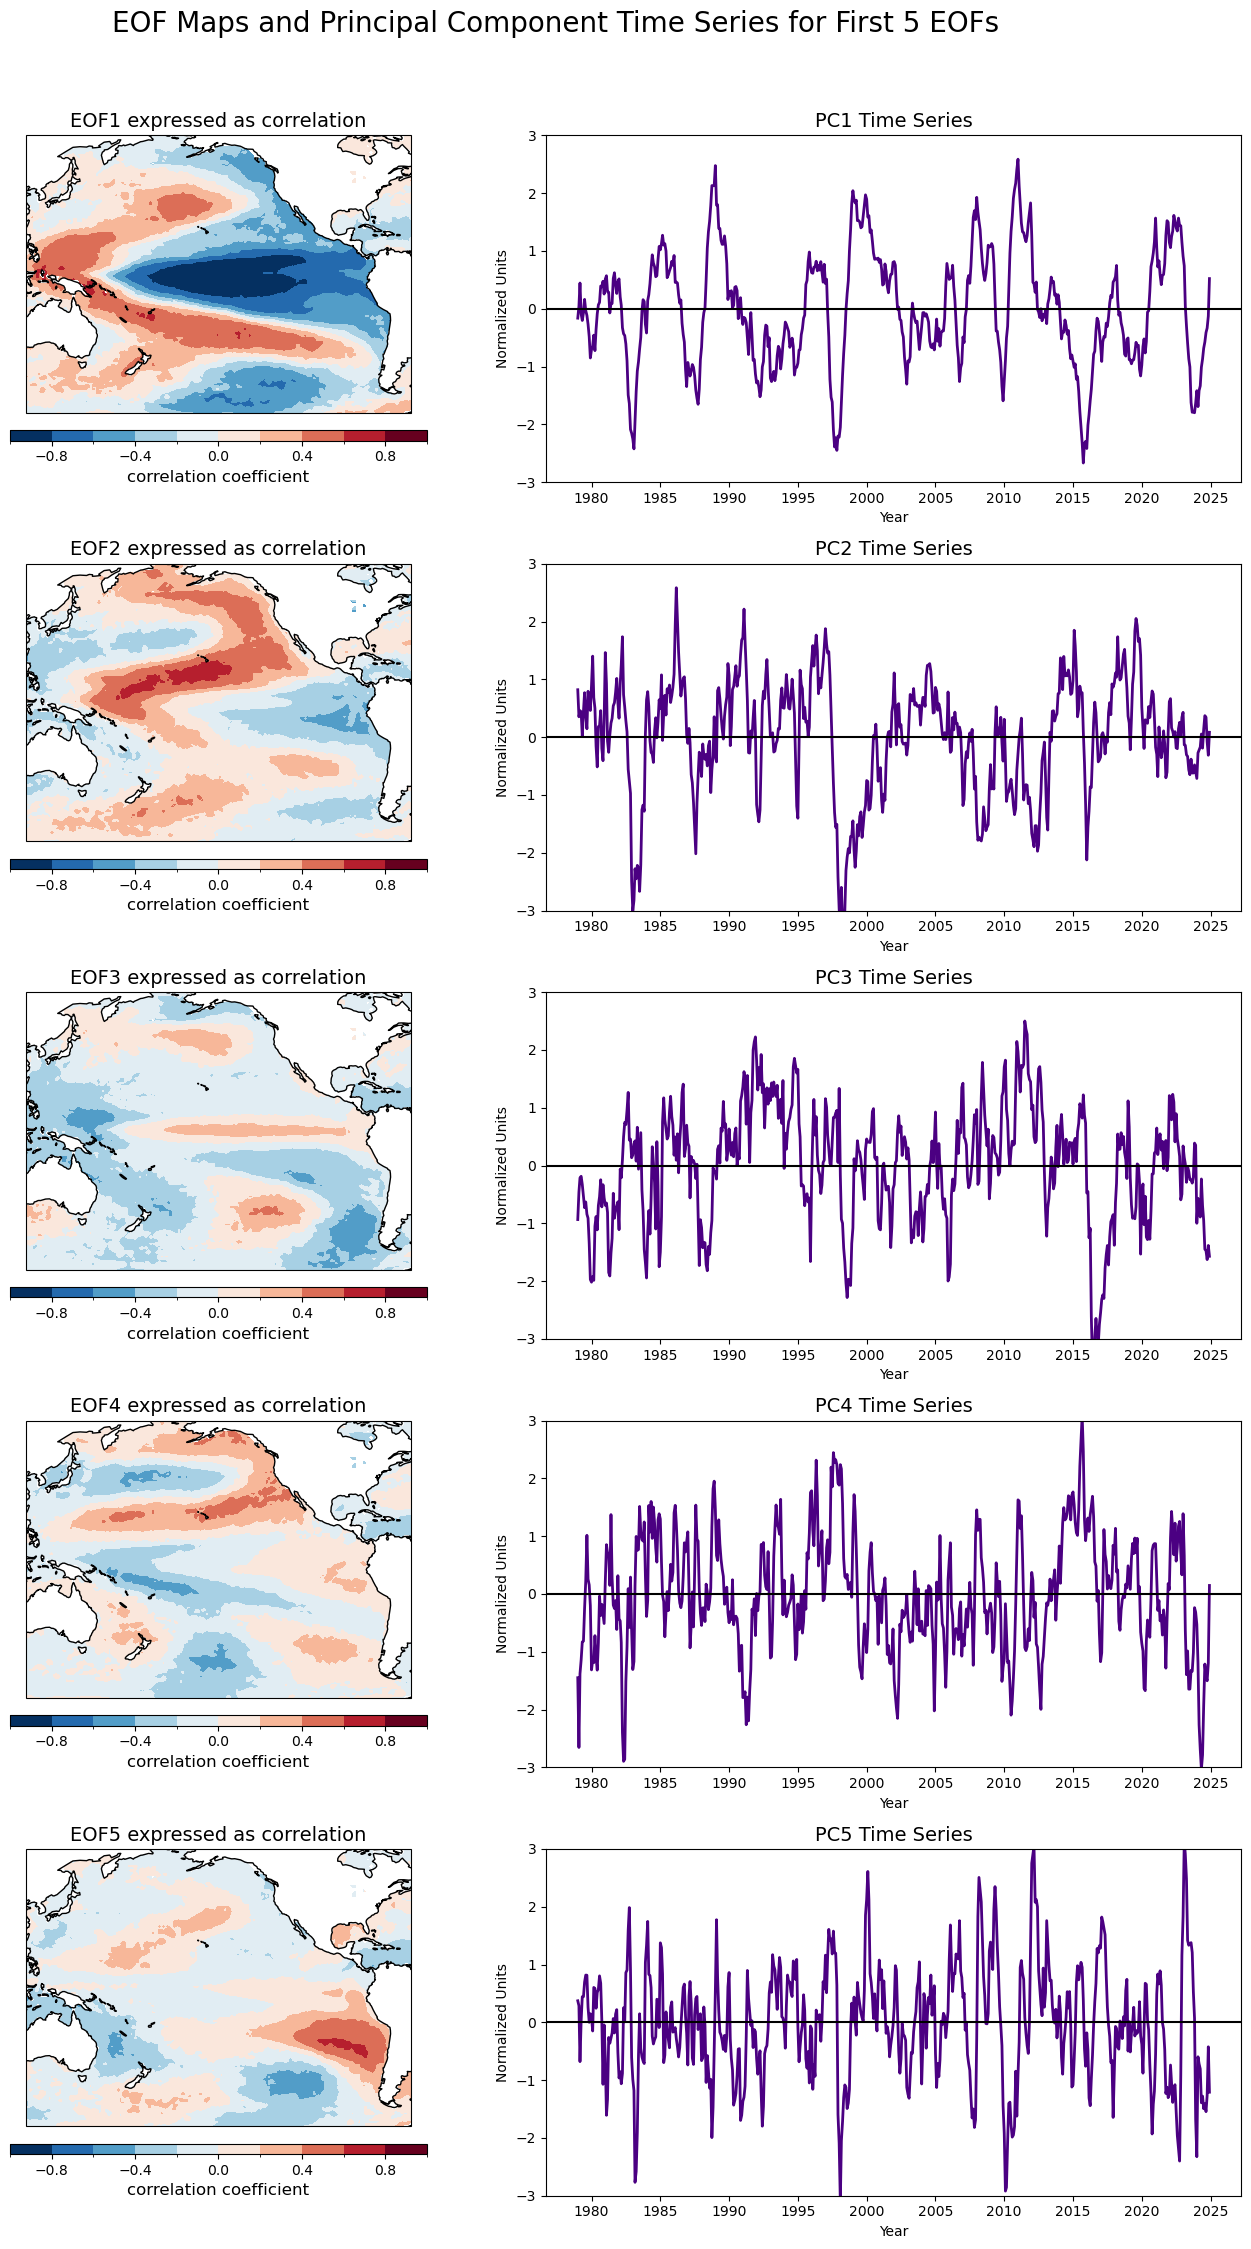

In [43]:
# Create a single figure with 10 sub-plots showing the correlation map and timeseries plot for the first 5 EOFs and PCs:

clevs = np.linspace(-1, 1, 11)
fig, axs = plt.subplots(5, 2, figsize=(14, 22))  
fig.suptitle('EOF Maps and Principal Component Time Series for First 5 EOFs', fontsize=20, y=1.02)

for i in range(5):
    # Remove the original axis and replace with a map axis at the same location
    ax_map = axs[i, 0]
    pos = ax_map.get_subplotspec()
    ax_map.remove()
    ax_map = fig.add_subplot(pos, projection=ccrs.PlateCarree(central_longitude=190))
    axs[i, 0] = ax_map

    fill = eof1[i].plot.contourf(ax=ax_map, levels=clevs, cmap=plt.cm.RdBu_r,
                                 add_colorbar=False, transform=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax_map.set_title(f'EOF{i+1} expressed as correlation', fontsize=14)

    cb = fig.colorbar(fill, ax=ax_map, orientation='horizontal', pad=0.05, aspect=40, shrink=0.6)
    cb.set_label('correlation coefficient', fontsize=12)

    # Right column: time series (no projection)
    ax_pc = axs[i, 1]
    pc1[:, i].plot(ax=ax_pc, color='indigo', linewidth=2)
    ax_pc.axhline(0, color='k')
    ax_pc.set_ylim(-3, 3)
    ax_pc.set_xlabel('Year')
    ax_pc.set_ylabel('Normalized Units')
    ax_pc.set_title(f'PC{i+1} Time Series', fontsize=14)

plt.tight_layout()

fig.savefig('eof_pc_summary.png', dpi=300, bbox_inches='tight')

### Step 5

Plot the percent of variance explained by the first 10 EOFs.

(1.423599340899687e-17, 0.19789718091487885)

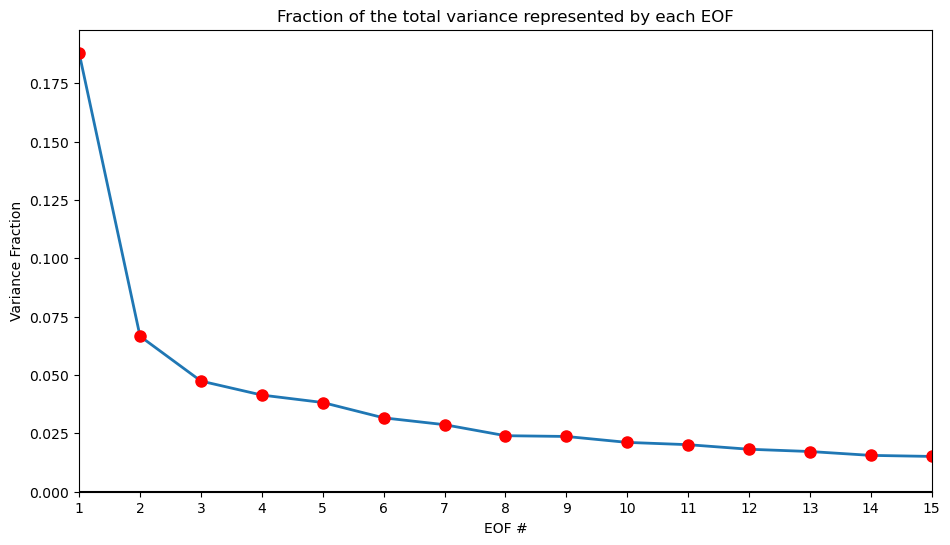

In [44]:
# Compute variance fraction explained by each EOF
varfrac = solver.varianceFraction()

# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

### Step 6

Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

In [45]:
reconstruction = solver.reconstructedField(5)
reconstruction

<xarray.DataArray 'sst' (time: 552, latitude: 130, longitude: 180)> Size: 52MB
dask.array<divide, shape=(552, 130, 180), dtype=float32, chunksize=(552, 130, 180), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 1kB 64.62 63.62 62.62 ... -62.38 -63.38 -64.38
  * longitude  (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4
    number     (time) int64 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    expver     (time) <U4 9kB dask.array<chunksize=(10,), meta=np.ndarray>
    month      (time) int64 4kB dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    long_name:  sst_reconstructed_with_5_EOFs

/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


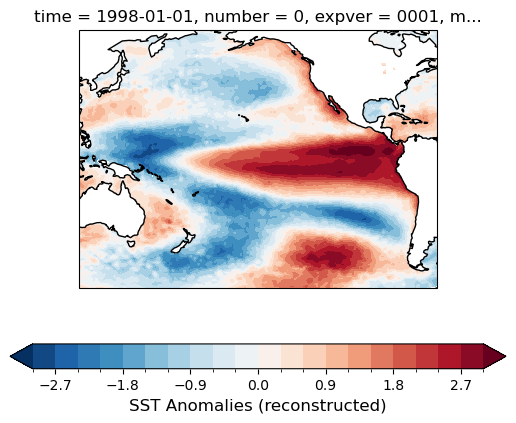

In [ ]:
# Plot the leading EOF expressed as correlation in the Pacific domain using the reconstructed SST anomalies.
# Looking at January 1, 1998 (strong El Nino event)

clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = reconstruction.sel(time='1998-01-15', method='nearest').plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies (reconstructed)', fontsize=12)

/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


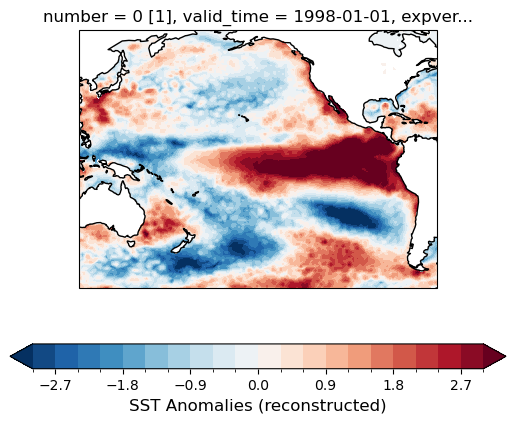

In [ ]:
# Plot the original SST anomalies for January 1, 1998 
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = sst_coarse.sel(valid_time='1998-01-15', method='nearest').plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies (reconstructed)', fontsize=12)

# reconstruction is close in the spatial pattern, but magnitude of anomalies is too low

In [58]:
# Calculate the correlation between sst_coarse and reconstruction

# first have to rename the time dimension in sst_coarse to match reconstruction
sst_coarse_renamed = sst_coarse.rename({'valid_time': 'time'})

# calculate correlation along time dimension
correlation = xr.corr(sst_coarse_renamed, reconstruction, dim='time')
correlation




<xarray.DataArray 'sst' (latitude: 130, longitude: 180)> Size: 94kB
dask.array<truediv, shape=(130, 180), dtype=float32, chunksize=(130, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 64.62 63.62 62.62 ... -62.38 -63.38 -64.38
  * longitude  (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4

/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


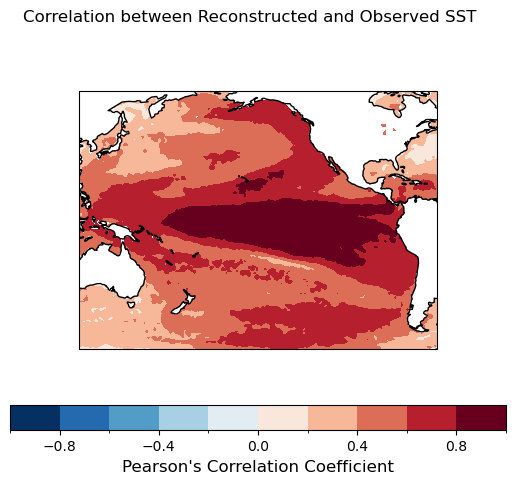

In [62]:
clevs = np.linspace(-1, 1, 11)  
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = correlation.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label("Pearson's Correlation Coefficient", fontsize=12)

plt.suptitle("Correlation between Reconstructed and Observed SST", fontsize=12, y=1.05)

fig.savefig('Correlation_Obs_Reconstructed_SST.png', dpi=300, bbox_inches='tight')

# Unsurprisingly, the correlation is highest in the central and eastern Pacific, where we see the strongest El Nino signals (EOF1 captures the ENSO variability)

### Step 7

Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

In [63]:
# standardize the TCRW data the same way as SST 
# Stack spatial dimensions into a single dimension
tcrw_stacked = anom['tcrw'].stack(points=('latitude', 'longitude'))

# Drop all-NaN points (e.g., land)
tcrw_valid = tcrw_stacked.dropna('points', how='all')

# Transpose so shape is (time, points)
tcrw_valid = tcrw_valid.transpose('valid_time', 'points')

# Fit scaler
scaler = preprocessing.StandardScaler().fit(tcrw_valid)

# To transform and put back into xarray:
tcrw_scaled = xr.full_like(tcrw_stacked, np.nan)
tcrw_scaled.loc[dict(points=tcrw_valid.points)] = scaler.transform(tcrw_valid)
tcrw_scaled = tcrw_scaled.unstack('points')

# have to coarsen the tcrw data the same way for correlation analysis later
tcrw_coarse = tcrw_scaled.coarsen(latitude=4, longitude=4, boundary='trim').mean()

tcrw_coarse

<xarray.DataArray 'tcrw' (valid_time: 552, latitude: 130, longitude: 180)> Size: 52MB
dask.array<mean_agg-aggregate, shape=(552, 130, 180), dtype=float32, chunksize=(1, 130, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 1kB 64.62 63.62 62.62 ... -63.38 -64.38
  * longitude   (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12

In [64]:
# check that dimensions line up
eof1[0]

<xarray.DataArray 'eofs' (latitude: 130, longitude: 180)> Size: 187kB
array([[        nan,         nan,         nan, ...,  0.08387537,
         0.08063284,  0.08253639],
       [        nan,         nan,         nan, ...,  0.08299114,
         0.1008708 ,  0.11257494],
       [        nan,         nan,         nan, ...,  0.08371988,
         0.11350408,  0.09730195],
       ...,
       [-0.07522015, -0.0822972 , -0.05443258, ...,  0.29479169,
         0.29668343,  0.27676481],
       [-0.12946264, -0.10076628, -0.09292528, ...,  0.267556  ,
         0.29028498,         nan],
       [-0.13891505, -0.11484799, -0.10490057, ...,         nan,
                nan,         nan]], shape=(130, 180))
Coordinates:
    mode       int64 8B 0
  * latitude   (latitude) float64 1kB 64.62 63.62 62.62 ... -62.38 -63.38 -64.38
  * longitude  (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4
Attributes:
    long_name:  correlation_between_pcs_and_sst

In [68]:
correlation_eof_tcrw = xr.corr(eof1[0], tcrw_coarse, dim='valid_time')
correlation_eof_tcrw

<xarray.DataArray (latitude: 130, longitude: 180)> Size: 187kB
dask.array<truediv, shape=(130, 180), dtype=float64, chunksize=(130, 180), chunktype=numpy.ndarray>
Coordinates:
    mode       int64 8B 0
  * latitude   (latitude) float64 1kB 64.62 63.62 62.62 ... -62.38 -63.38 -64.38
  * longitude  (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4

/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


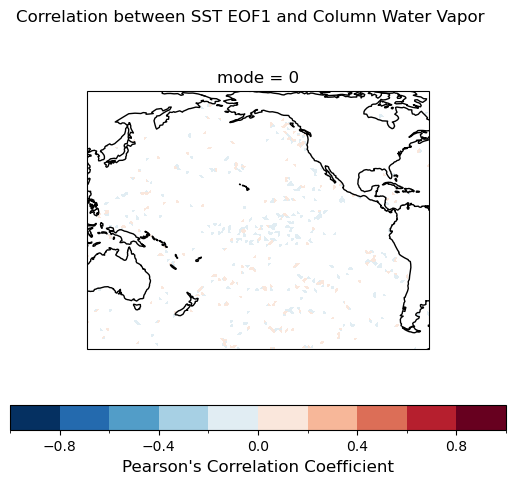

In [69]:
# Plot the correlation between EOF1 and the standardized, detrended, deseasonalized mean monthly water vapor

clevs = np.linspace(-1, 1, 11)  
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = correlation_eof_tcrw.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label("Pearson's Correlation Coefficient", fontsize=12)

plt.suptitle("Correlation between SST EOF1 and Column Water Vapor", fontsize=12, y=1.05)

fig.savefig('Correlation_EOF1_TCRW.png', dpi=300, bbox_inches='tight')

__Interesting observations:__

There's basically no correlation between EOF1 and the column water vapor



In [71]:
# Since that was a bust, going to look at the correlation between the reconstructed SSTs based just on EOF1 and the column water vapor

reconstruction_eof1 = solver.reconstructedField(1)
reconstruction_eof1

# first have to rename the time dimension in sst_coarse to match reconstruction
tcrw_coarse_renamed = tcrw_coarse.rename({'valid_time': 'time'})

# calculate correlation along time dimension
correlation_eof_tcrw = xr.corr(tcrw_coarse_renamed, reconstruction_eof1, dim='time')
correlation_eof_tcrw


<xarray.DataArray (latitude: 130, longitude: 180)> Size: 94kB
dask.array<truediv, shape=(130, 180), dtype=float32, chunksize=(130, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 64.62 63.62 62.62 ... -62.38 -63.38 -64.38
  * longitude  (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4

/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


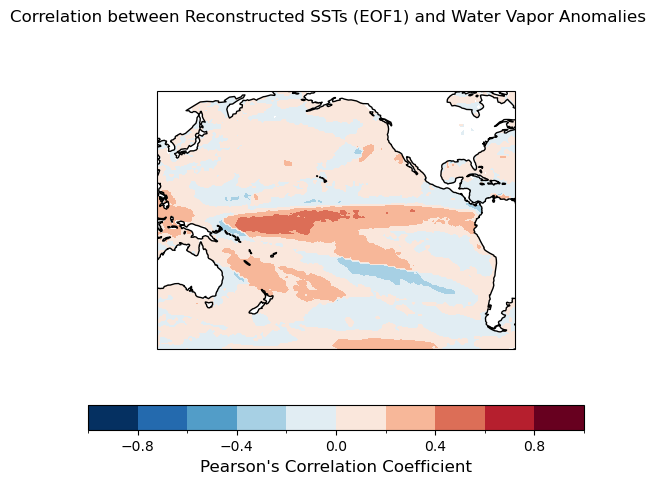

In [72]:
# Plot the correlation between the SST reconstruction based solely on EOF1 and the standardized, detrended, deseasonalized mean monthly water vapor

clevs = np.linspace(-1, 1, 11)  
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = correlation_eof_tcrw.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label("Pearson's Correlation Coefficient", fontsize=12)

plt.suptitle("Correlation between Reconstructed SSTs (EOF1) and Water Vapor Anomalies", fontsize=12, y=1.05)

fig.savefig('Correlation_Reconstructed_SST_TCRW.png', dpi=300, bbox_inches='tight')

In [ ]:
clevs = np.linspace(-1, 1, 11)
fig, axs = plt.subplots(1, 2, figsize=(14, 8))  

# Remove the original axis and replace with a map axis at the same location
ax_map = axs[i, 0]
pos = ax_map.get_subplotspec()
ax_map.remove()
ax_map = fig.add_subplot(pos, projection=ccrs.PlateCarree(central_longitude=190))
axs[i, 0] = ax_map

fill = eof1[i].plot.contourf(ax=ax_map, levels=clevs, cmap=plt.cm.RdBu_r,
                                add_colorbar=False, transform=ccrs.PlateCarree())
ax_map.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax_map.set_title(f'EOF{i+1} expressed as correlation', fontsize=14)

cb = fig.colorbar(fill, ax=ax_map, orientation='horizontal', pad=0.05, aspect=40, shrink=0.6)
cb.set_label('correlation coefficient', fontsize=12)

# Right column: time series (no projection)
ax_pc = axs[i, 1]
pc1[:, i].plot(ax=ax_pc, color='indigo', linewidth=2)
ax_pc.axhline(0, color='k')
ax_pc.set_ylim(-3, 3)
ax_pc.set_xlabel('Year')
ax_pc.set_ylabel('Normalized Units')
ax_pc.set_title(f'PC{i+1} Time Series', fontsize=14)

plt.tight_layout()

fig.savefig('eof_pc_summary.png', dpi=300, bbox_inches='tight')

__Observations__

- That's a bit more interesting - the strongest correlations are in the tropical Pacific (specifically the western tropical Pacific). 
- The sign of my EOF1 is consistent with the La Nina phase of ENSO (cooler than average tropical Pacific).
- During La Nina, convection over the western Pacific is enhanced relative to ENSO-neutral conditions, so it makes sense to see a positive correlation between water vapor over the western Pacific and a La Nina SST pattern


/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


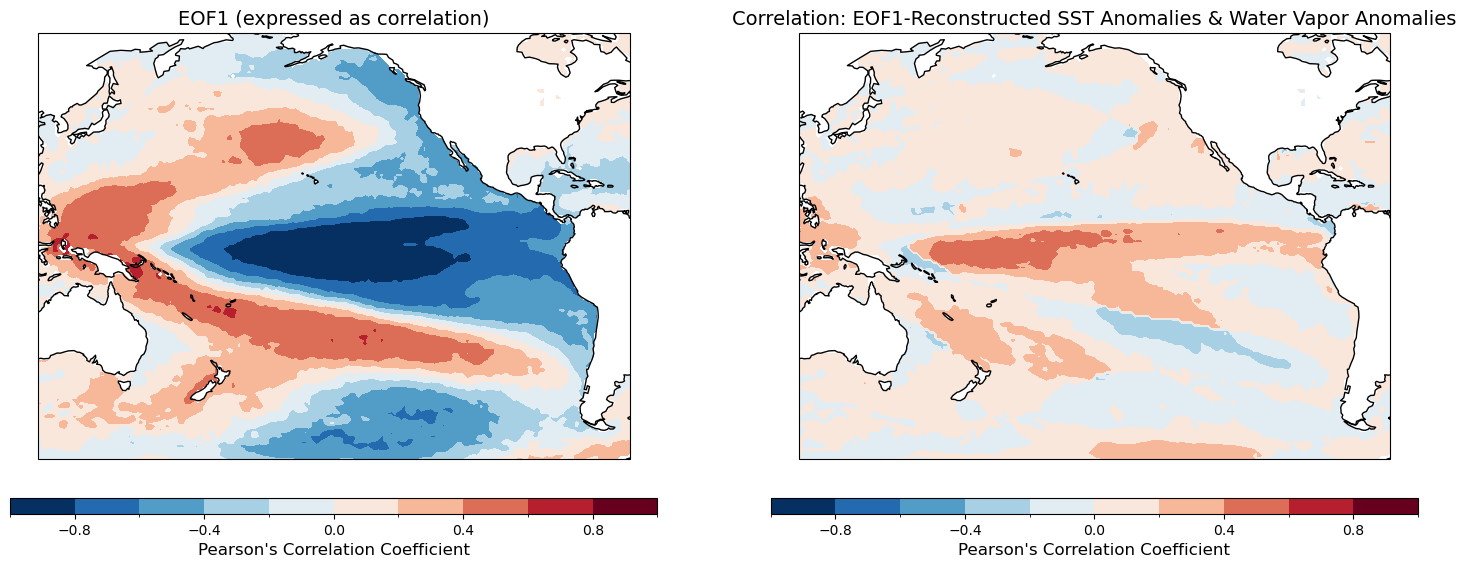

In [74]:
# Plot EOF1[0] and correlation_eof_tcrw side by side as maps with consistent style
clevs = np.linspace(-1, 1, 11)
fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=190)})

# Left: EOF1[0]
ax0 = axs[0]
fill0 = eof1[0].plot.contourf(ax=ax0, levels=clevs, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
ax0.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax0.set_title('EOF1 (expressed as correlation)', fontsize=14)
cb0 = fig.colorbar(fill0, ax=ax0, orientation='horizontal', pad=0.07, aspect=40, shrink=0.8)
cb0.set_label("Pearson's Correlation Coefficient", fontsize=12)

# Right: correlation_eof_tcrw
ax1 = axs[1]
fill1 = correlation_eof_tcrw.plot.contourf(ax=ax1, levels=clevs, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax1.set_title('Correlation: EOF1-Reconstructed SST Anomalies & Water Vapor Anomalies', fontsize=14)
cb1 = fig.colorbar(fill1, ax=ax1, orientation='horizontal', pad=0.07, aspect=40, shrink=0.8)
cb1.set_label("Pearson's Correlation Coefficient", fontsize=12)

plt.tight_layout()

fig.savefig('EOF1_reconstruction_correlation with Water Vapor Anomalies.png', dpi=300, bbox_inches='tight')

plt.show()